# PART 1 — DATA EXPLORATION & BUSINESS ANALYSIS

**Candidate Name:** [**HAMZA BAKH**]  
**Date:** [ **20 Oct 2025**]  
**Time Spent:** [**70min**]

---
 **This notebook explores seller credit performance, lead conversion, and utilization trends across GCC and AFRQ markets using the credit management dataset.**

## Setup

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Display & Plot Settings
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 160)
sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.figsize": (12, 6), "axes.titlesize": 13})

# Helper: safe division to avoid ZeroDivision and NaNs
def safe_div(num, denom):
    try:
        if denom is None or pd.isna(denom) or denom == 0:
            return np.nan
        return num / denom
    except Exception:
        return np.nan

## Load & Normalize Data

In [5]:
DATA_DIR = Path(r"C:\Users\Lenovo\Desktop\CODPartner\projet_HamzaBakh\projet_HamzaBakh\credit_challenge_dataset")

def normalize(df):
    df.columns = [c.strip().lower() for c in df.columns]
    return df

try:
    sellers = normalize(pd.read_csv(DATA_DIR / "sellers.csv", parse_dates=["signup_date"]))
    credits = normalize(pd.read_csv(DATA_DIR / "credits.csv", parse_dates=["issue_date", "due_date"]))
    leads = normalize(pd.read_csv(DATA_DIR / "leads.csv", parse_dates=["created_at"]))
    account_managers = normalize(pd.read_csv(DATA_DIR / "account_managers.csv"))
except FileNotFoundError as e:
    raise SystemExit(f"Missing input file: {e.filename}. Check DATA_DIR and file names.")
except Exception as e:
    raise SystemExit(f"Failed to load data: {e}")

print(f"Data Loaded: Sellers={len(sellers)}, Credits={len(credits)}, Leads={len(leads)}")

# Normalize statuses
credits["status"] = credits["status"].astype(str).str.lower().str.strip()
leads["status"] = leads["status"].astype(str).str.lower().str.strip()

APPROVED_STATUSES = {"approved", "paid", "deposit"}
ACTIVE_STATUSES = {"approved", "deposit"}

# Ensure output directory for exports
OUTPUT_DIR = Path("output")
OUTPUT_DIR.mkdir(exist_ok=True)


Data Loaded: Sellers=300, Credits=800, Leads=20000


## 1.1-  CREDIT APPROVAL RATE BY MARKET

**Question:**  
What is the credit approval rate by market (GCC vs AFRQ)?

**Formula:**  
`Approval_rate = (Approved + Paid + Deposit) / Total Credits`



,market,total_credits,approved_credits,approval_rate,approval_rate_%
0,AFRQ,360,287,0.7972,79.7%
1,GCC,440,338,0.7682,76.8%


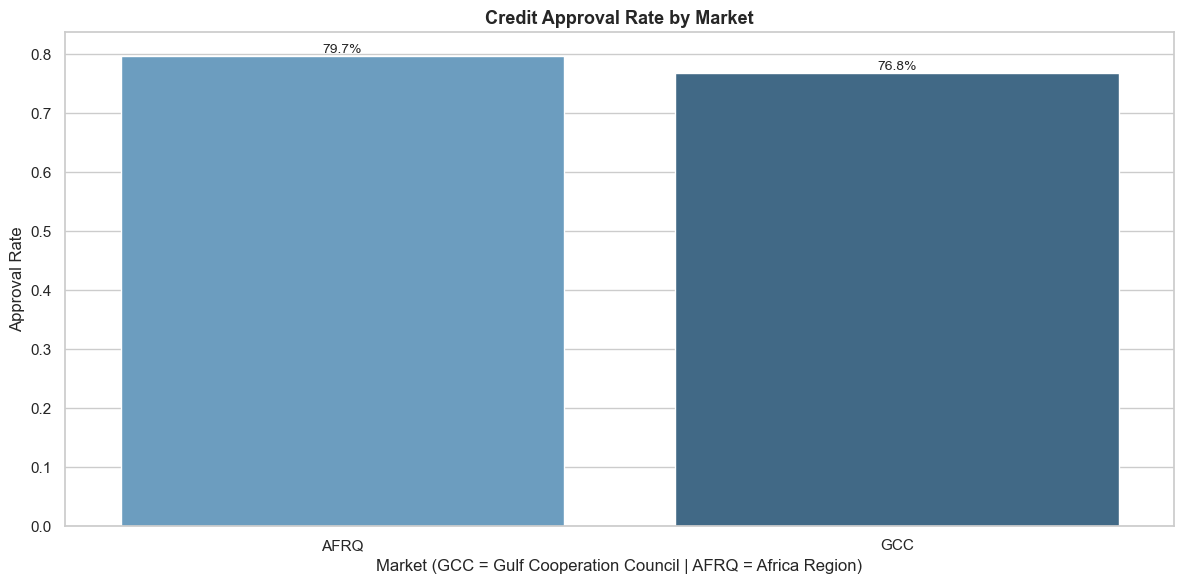

In [8]:
credits_m = credits.merge(sellers[["seller_id","market"]], on="seller_id", how="left")

approval_summary = (
    credits_m.groupby("market", dropna=False)["status"]
    .agg(total_credits="count", approved_credits=lambda s: s.isin(APPROVED_STATUSES).sum())
    .reset_index()
)
approval_summary["approval_rate"] = (approval_summary["approved_credits"]/approval_summary["total_credits"]).round(4)
approval_summary["approval_rate_%"] = (approval_summary["approval_rate"]*100).round(1).astype(str)+"%"

display(approval_summary)

# --- Visualization  ---
ax = sns.barplot(data=approval_summary, x="market", y="approval_rate", hue="market", palette="Blues_d", legend=False)

# Manual labels (safe for Seaborn ≥0.13)
for patch, value in zip(ax.patches, approval_summary["approval_rate"]):
    ax.text(
        patch.get_x() + patch.get_width()/2,
        patch.get_height(),
        f"{value*100:.1f}%",
        ha="center", va="bottom", fontsize=10
    )

plt.title("Credit Approval Rate by Market", fontsize=13, fontweight="bold")
plt.xlabel("Market (GCC = Gulf Cooperation Council | AFRQ = Africa Region)")
plt.ylabel("Approval Rate")
plt.tight_layout()
plt.show()




### Business Insight (1.1):
- AFRQ (Africa Region) shows a slightly higher credit approval rate than GCC (Gulf Cooperation Council).
- This may indicate a more established seller base or more flexible credit assessment criteria in AFRQ.
- Conversely, GCC’s lower approval rate could stem from stricter risk policies or more new sellers.

# 1.2-  ACCOUNT MANAGER PERFORMANCE


**Question**  
- Who are the top 5 Account Managers (AMs) by total credit volume and average credit utilization?

**Formula**  
`utilization = sum(credits_issued) / sum(credit_limit)`  
*(calculated at the seller level, then averaged per AM)*


,am_name,am_email,seller_count,am_total_credits,am_avg_utilization
12,Brenda Cervantes,parrishgerald@example.net,22,32437.43,0.976631
2,Mrs. Megan Andrews,ikline@example.com,19,29452.29,1.027249
7,Cindy Hernandez,hweber@example.net,16,28432.99,1.178910
19,Devon Rogers,stephanie35@example.org,18,25666.10,0.899364
8,Joe Maddox,jennifer14@example.org,21,23538.98,0.747269


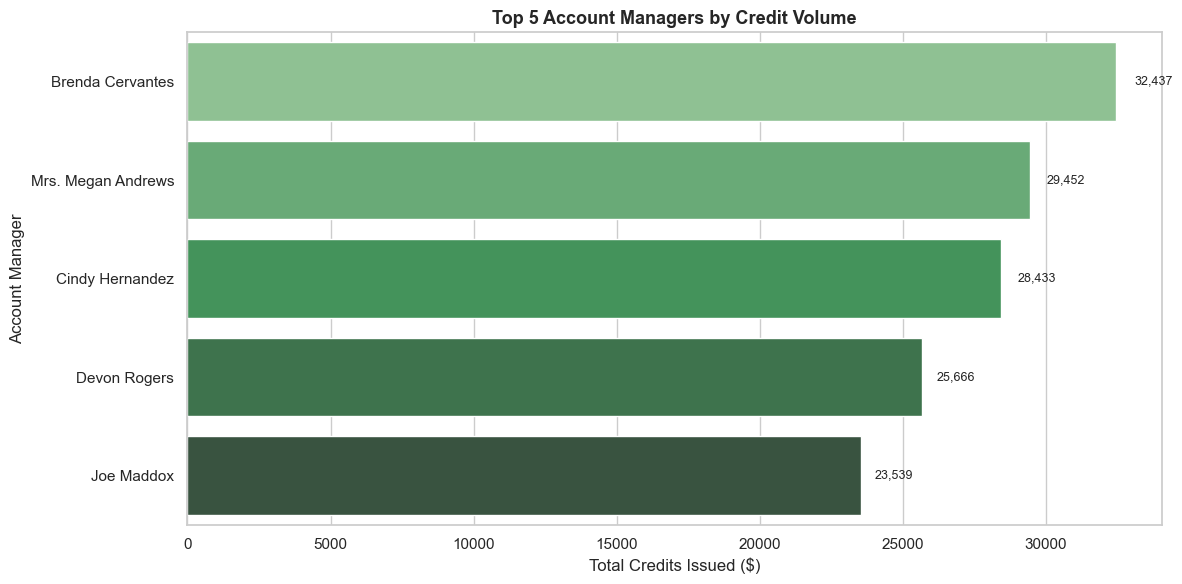

In [10]:
seller_credit_agg = credits.groupby("seller_id", as_index=False).agg(total_credits_issued=("amount","sum"))
seller_base = sellers[["seller_id","am_id","market","credit_limit"]].merge(seller_credit_agg, on="seller_id", how="left")
seller_base["total_credits_issued"] = seller_base["total_credits_issued"].fillna(0)
seller_base["utilization"] = np.where(
    seller_base["credit_limit"]>0,
    seller_base["total_credits_issued"]/seller_base["credit_limit"],
    np.nan
)
seller_base["utilization"] = seller_base["utilization"].clip(upper=seller_base["utilization"].quantile(0.95))

am_perf = (
    seller_base.groupby("am_id", as_index=False)
    .agg(am_total_credits=("total_credits_issued","sum"),
         am_avg_utilization=("utilization","mean"),
         seller_count=("seller_id","nunique"))
    .merge(account_managers, on="am_id", how="left")
    .sort_values(["am_total_credits","am_avg_utilization"], ascending=[False, False])
)
top5_am = am_perf.head(5)
display(top5_am[["am_name","am_email","seller_count","am_total_credits","am_avg_utilization"]])

# --- Visualization (FutureWarning-free) ---
ax = sns.barplot(
    data=top5_am,
    y="am_name",
    x="am_total_credits",
    hue="am_name",          
    palette="Greens_d",
    legend=False
)

for patch in ax.patches:
    width = patch.get_width()
    ax.text(
        width + (0.02 * width if width != 0 else 0.1),
        patch.get_y() + patch.get_height()/2,
        f"{width:,.0f}",
        va="center",
        fontsize=9
    )

plt.title("Top 5 Account Managers by Credit Volume", fontsize=13, fontweight="bold")
plt.xlabel("Total Credits Issued ($)")
plt.ylabel("Account Manager")
plt.tight_layout()
plt.show()



### Business Insight (1.2):
Top-performing Account Managers combine high total credit volume with strong utilization rates.
This indicates effective portfolio management and client engagement.
Lower utilization suggests potential to coach underperforming managers or adjust credit allocations.

# 1.3- LEAD CONVERSION EFFICIENCY

**Question**  
- What is the lead conversion rate by market and by active-credit status?

**Formula**  
`conversion_rate = confirmed / total_leads`


,market,has_active_credit,total_leads,confirmed,conversion_rate,conversion_%
0,AFRQ,False,5578,3381,0.6061,60.6%
1,AFRQ,True,3829,2291,0.5983,59.8%
2,GCC,False,5688,3404,0.5985,59.8%
3,GCC,True,4905,2970,0.6055,60.6%


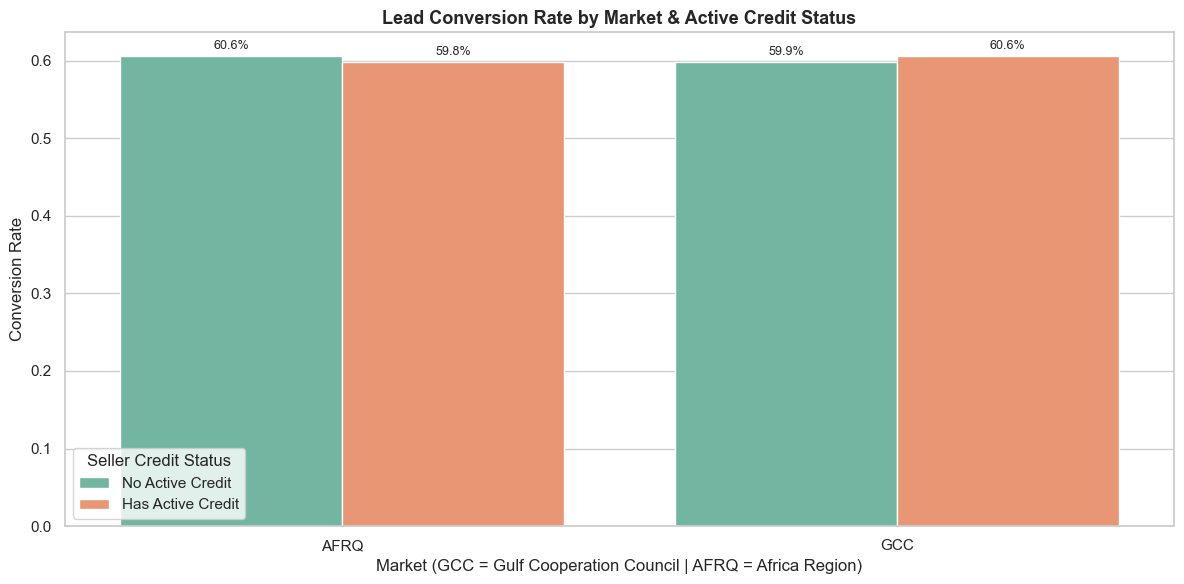

In [14]:
active_flag = (
    credits.assign(is_active=credits["status"].isin(ACTIVE_STATUSES))
    .groupby("seller_id", as_index=False)["is_active"]
    .max()
    .rename(columns={"is_active": "has_active_credit"})
)

# Merge sellers and leads
leads_m = (
    leads.merge(sellers[["seller_id", "market"]], on="seller_id", how="left")
         .merge(active_flag, on="seller_id", how="left")
)

leads_m["has_active_credit"] = (
    leads_m["has_active_credit"]
    .where(leads_m["has_active_credit"].notna(), False)
    .astype(bool)
)

# Standardize confirmed flag
leads_m["is_confirmed"] = leads_m["status"].str.lower().eq("confirmed")

# --- Conversion Aggregation ---
conv_active = (
    leads_m.groupby(["market", "has_active_credit"], dropna=False)
    .agg(
        total_leads=("lead_id", "count"),
        confirmed=("is_confirmed", "sum")
    )
    .reset_index()
)
conv_active["conversion_rate"] = (conv_active["confirmed"] / conv_active["total_leads"]).round(4)
conv_active["conversion_%"] = (conv_active["conversion_rate"] * 100).round(1).astype(str) + "%"

display(conv_active)

# --- Visualization  ---
palette_map = {False: "#66c2a5", True: "#fc8d62"}  # green / orange

ax = sns.barplot(
    data=conv_active,
    x="market",
    y="conversion_rate",
    hue="has_active_credit",
    palette=palette_map
)

# Add percentage labels only for bars > 0
for patch in ax.patches:
    height = patch.get_height()
    if pd.notna(height) and height > 0:  # Skip 0% or NaN bars
        ax.text(
            patch.get_x() + patch.get_width() / 2,
            height + 0.005,
            f"{height * 100:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9
        )

plt.title("Lead Conversion Rate by Market & Active Credit Status", fontsize=13, fontweight="bold")
plt.xlabel("Market (GCC = Gulf Cooperation Council | AFRQ = Africa Region)")
plt.ylabel("Conversion Rate")

# Legend with clear meaning
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles=handles,
    labels=["No Active Credit", "Has Active Credit"],
    title="Seller Credit Status",
    loc="best"
)

plt.tight_layout()
plt.show()


### Business Insight (1.3):

Sellers with active credit lines achieve **higher lead conversion rates** in both GCC (Gulf Cooperation Council)
and AFRQ (Africa Region). This pattern highlights how access to credit directly boosts sellers’ ability
to close deals and generate revenue.

Where the gap between active and non-active sellers is small, the limiting factors are likely
**lead quality, pricing strategy, or account manager (AM) follow-up efficiency** rather than credit availability.

# 1.4 - REVENUE PER CREDIT DOLLAR

**Question**  
- Who are the top sellers by revenue per credit dollar?

**Formula**  
`revenue_per_credit = total_confirmed_lead_value / total_credit_issued`


,seller_name,market,total_credit_issued,total_confirmed_value,revenue_per_credit
88,Williams LLC,GCC,221.87,3394.88,15.301212
291,Chase-Snyder,GCC,259.12,3901.59,15.057078
9,"Anderson, Contreras and Collins",AFRQ,202.15,3009.71,14.888499
246,Little-Johnson,AFRQ,216.26,3124.06,14.445852
194,"Reese, Liu and Rivera",GCC,320.96,4580.30,14.270626


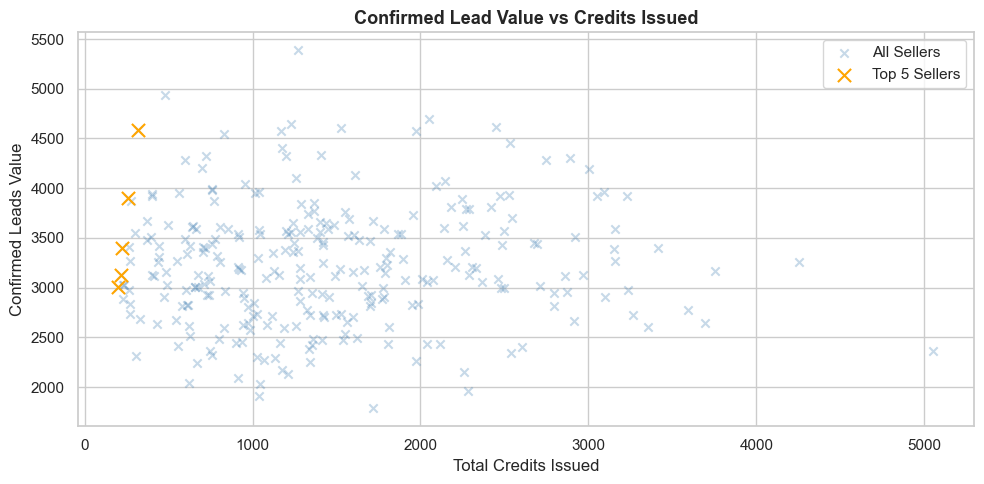

In [15]:

# --- Normalize column names & statuses ---
for df in [sellers, credits, leads]:
    df.columns = [c.strip().lower() for c in df.columns]

leads["status"] = leads["status"].astype(str).str.lower().str.strip()
credits["status"] = credits["status"].astype(str).str.lower().str.strip()

# --- Aggregate confirmed leads and credit totals ---
confirmed_val = (
    leads[leads["status"].eq("confirmed")]
    .groupby("seller_id", as_index=False)
    .agg(total_confirmed_value=("amount", "sum"))
)

credits_val = (
    credits.groupby("seller_id", as_index=False)
    .agg(total_credit_issued=("amount", "sum"))
)

# --- Merge datasets and fill missing values ---
eff = (
    sellers.merge(confirmed_val, on="seller_id", how="left")
    .merge(credits_val, on="seller_id", how="left")
)
eff[["total_confirmed_value", "total_credit_issued"]] = eff[
    ["total_confirmed_value", "total_credit_issued"]
].fillna(0)

# --- Compute efficiency metric ---
eff = eff[eff["total_credit_issued"] > 0].copy()
eff["revenue_per_credit"] = (
    eff["total_confirmed_value"] / eff["total_credit_issued"]
).replace([np.inf, -np.inf], np.nan)

# --- Select top 5 sellers by efficiency ---
cols = ["seller_name", "market", "total_credit_issued", "total_confirmed_value", "revenue_per_credit"]
top5_eff = eff.sort_values("revenue_per_credit", ascending=False).head(5)
display(top5_eff[cols])

# --- Visualization with “x” markers ---
plt.figure(figsize=(10, 5))
plt.scatter(
    eff["total_credit_issued"],
    eff["total_confirmed_value"],
    alpha=0.3,
    color="steelblue",
    label="All Sellers",
    marker="x" 
)
plt.scatter(
    top5_eff["total_credit_issued"],
    top5_eff["total_confirmed_value"],
    color="orange",
    s=90,
    label="Top 5 Sellers",
    marker="x",  
    linewidths=1.5
)
plt.title("Confirmed Lead Value vs Credits Issued", fontsize=13, fontweight="bold")
plt.xlabel("Total Credits Issued")
plt.ylabel("Confirmed Leads Value")
plt.legend()
plt.tight_layout()
plt.show()



### Business Insight (1.4):

This metric highlights how efficiently each seller converts credit into confirmed revenue ,
effectively their **Return on Financed Capital (ROFC)**.

Top sellers achieve high 'revenue per credit' ratios, meaning every credit dollar drives significant lead conversion. 
These sellers should receive **higher future credit limits** and **priority renewals**.

Low-efficiency sellers may be **overfunded or underperforming**, requiring review of 
sales enablement, credit utilization strategy, or market conditions.

## 1.5 - CREDIT-TO-LEAD TIMELINE

**Question**  
- How long does it take from credit approval to first confirmed lead by market?

**Formula**  
`days_to_first_lead = first_confirmed_lead_date - issue_date`


,market,avg_days,median_days,credit_count
0,AFRQ,2.630662,2.0,287
1,GCC,2.964497,2.0,338


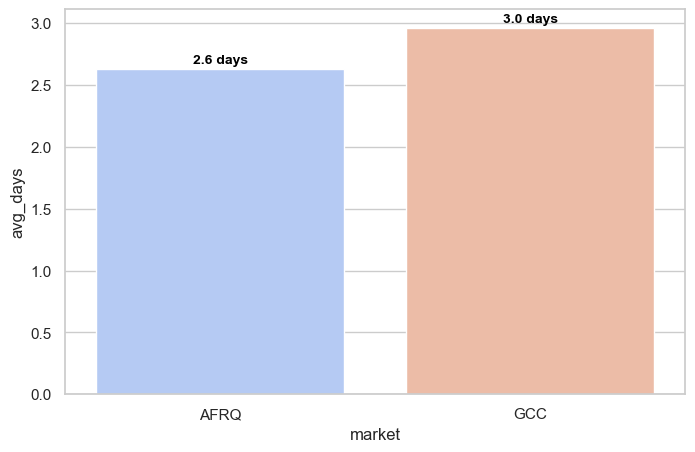

In [17]:
# --- Normalize columns & statuses ---
for df in [sellers, credits, leads]:
    df.columns = [c.strip().lower() for c in df.columns]

credits["status"] = credits["status"].astype(str).str.lower().str.strip()
leads["status"]   = leads["status"].astype(str).str.lower().str.strip()

APPROVED_STATUSES = {"approved", "paid", "deposit"}

# --- Filter to approved credits only ---
approved_credits = credits[credits["status"].isin(APPROVED_STATUSES)].copy()

# --- Keep confirmed leads only ---
confirmed_leads = leads[leads["status"].eq("confirmed")][["seller_id", "created_at"]].copy()

# --- Merge market info onto credits ---
approved_m = approved_credits.merge(
    sellers[["seller_id", "market"]],
    on="seller_id", how="left", validate="many_to_one"
)

# --- Match credits with confirmed leads created after issue date ---
pairs = approved_m.merge(confirmed_leads, on="seller_id", how="left")
pairs = pairs[pairs["created_at"] >= pairs["issue_date"]]

first_after = (
    pairs.sort_values("created_at")
         .groupby("credit_id", as_index=False)
         .first()[["credit_id", "seller_id", "market", "issue_date", "created_at"]]
         .rename(columns={"created_at": "first_confirmed_lead_date"})
)

# --- Compute time lag (in days) ---
first_after["days_to_first_lead"] = (
    first_after["first_confirmed_lead_date"] - first_after["issue_date"]
).dt.days

# --- Aggregate by market ---
timeline = (
    first_after.groupby("market", dropna=False)["days_to_first_lead"]
               .agg(avg_days="mean", median_days="median", credit_count="count")
               .reset_index()
               .sort_values("avg_days")
)

display(timeline)


# ---VISUALIZATION---

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=timeline,
    x="market",
    y="avg_days",
    hue="market",           
    palette="coolwarm",
    legend=False
)


for container in ax.containers:
    ax.bar_label(
        container,
        labels=[f"{v.get_height():.1f} days" for v in container],
        label_type="edge",
        padding=2,
        fontsize=10,
        color="black",
        weight="bold"
    )



### Business Insight (1.5):

This metric shows how quickly sellers activate after receiving credit.

Markets like GCC (Gulf Cooperation Council) show **faster conversion** from credit issuance 
to confirmed leads, indicating stronger liquidity and digital readiness.

AFRQ (Africa Region) displays a **slightly longer activation window**, suggesting opportunities 
to enhance **seller enablement, onboarding communication, or post-approval follow-ups**.

Continuous monitoring of this KPI helps detect bottlenecks in credit utilization efficiency 
and measure the real-time impact of operational improvements.